# INM707 Deep Learning: Optimization - Coursework #
##  Part 1:Basic - London Tube Shortest Path Using Q Learning##
## Author - Abin Abraham ##
The task is to identify the shortest path between any station in the map to a destination station with reinforcement learning using the Q-learning algorithm.

## Load libraries for data preparation, graphs, plotting ##

In [22]:
#Code adapted from INM707 Tutorial 5
#Importing libraries
import numpy as np
import math
from collections import deque
import random
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tabulate import tabulate

## Creation of transport network ##

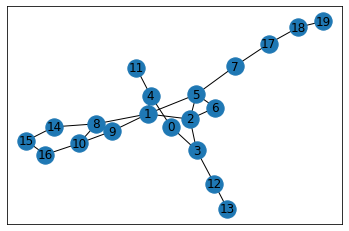

<Figure size 1440x720 with 0 Axes>

In [50]:
#Creating the virtual transport network
#Each node from 0-19 defines a station and the edge represents the connection between stations
edges=[(0,4),(4,0),(0,3),(3,0),(1,2),(2,1),(1,4),(4,1),(1,8),(8,1),(1,9),(9,1),(2,3),(3,2),(2,6),(6,2),(1,5),(5,1),(2,5),(5,2),(5,6),(6,5),(7,5),(5,7),(8,9),(9,8),(8,10),(10,8),(9,10),(10,9),(4,11),(3,12),(12,13),(8,14),(14,15),(15,16),(16,10),(7,17),(17,18),(18,19)];
G=nx.Graph();
G.add_edges_from(edges);
pos=nx.spring_layout(G);
nx.draw_networkx_nodes(G,pos);
nx.draw_networkx_edges(G,pos);
nx.draw_networkx_labels(G,pos);

fig= plt.figure(figsize=(20,10))
plt.show()

In [24]:
# Initialising R and Q matrix

#R matrix initialised with -100 to add a penalty for all nodes (reward of -100) unless there is a connection to another node.
#This basically simulates that there is no connection between the nodes and due to the heavy penalty,
#in the long run the agent will avoid the path.
R=np.ones([20,20])*-100
Q=np.zeros([20,20])

#Assigning reward of 1 for paths with connections
for g in range(0,19):
    for x in G[g]:
        R[x,g]=1
        R[g,x]=1
        
#Assigning last node as destination and hence reward as 100 for connections between penultimate stations and destination
for x in G[10]:
    R[x,10]=100;
    
#Assigning reward of 100 to remain in destination station
R[10,10]=100

## Display R matrix ##

In [25]:
col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
table = tabulate(R,col_headers,showindex="always")
print(table)

       0     1     2     3     4     5     6     7     8     9    10    11    12    13    14    15    16    17    18    19
--  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0  -100  -100  -100     1     1  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
 1  -100  -100     1  -100     1     1  -100  -100     1     1  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
 2  -100     1  -100     1  -100     1     1  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
 3     1  -100     1  -100  -100  -100  -100  -100  -100  -100  -100  -100     1  -100  -100  -100  -100  -100  -100  -100
 4     1     1  -100  -100  -100  -100  -100  -100  -100  -100  -100     1  -100  -100  -100  -100  -100  -100  -100  -100
 5  -100     1     1  -100  -100  -100     1     1  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100  -100
 6  -100  -100  

## Display Inital Q matrix ##

In [26]:
col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
table = tabulate(Q,col_headers,showindex="always")
print(table)

      0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 1    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 2    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 3    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 4    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 5    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 6    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0  

In [27]:
#Function to determine the next state based on the epsilon greedy policy
def next_state(start,epsilon):
    random_value=random.uniform(0,1);
    
    #Select the next station either using explore or exploitation
    if random_value<epsilon:
        sample=G[start]#explore - select the connected station
    else:
        sample=np.where(Q[start,] == np.max(Q[start,]))[0]#exploit - select the station that maxmimizes Q value
     
    #When there is more than 1 station returned select 1 among them
    if(len(sample)>1):
        next_node= int(np.random.choice(sample,1))# selecting any one among the nodes with max Q value
    else:
        next_node=list(sample)[0]
    return next_node

In [28]:
#Function to update Q value
def updateQ(node1,node2,alpha,gamma):
    #Determining node with highest Q value
    max_index = np.where(Q[node2,] == np.max(Q[node2,]))[0] 
    if max_index.shape[0] > 1:
        max_index = int(np.random.choice(max_index, size = 1))
    else:
        max_index = int(max_index)
    max_value = Q[node2, max_index]
    
    #Updating Q value using bellman equation
    Q[node1, node2] = int((1-alpha)*Q[node1, node2]+alpha*(R[node1, node2] + gamma * max_value)) 

## Experiment with different values for alpha, gamma and epsilon ##

In [29]:
# Hyperparameters
alphas = [0.2,0.4,0.6,0.8]
gammas = [0.2,0.4,0.6,0.8]
epsilons = [0.99,0.80,0.70,0.55]
#epsilondecays=[0.9999,0.999,0.99,0.9]

episodes=1000;

#Initialising matrix for steps per episode and rewards per episode
episode_steps=np.zeros([episodes,1]);
episode_rewards=np.zeros([episodes,1]);

In [30]:
#Script to evluate the performance across different learning rate -alphas , discount rate - gammas and epsilon
for alpha in alphas:
    for gamma in gammas:
        for epsilon in epsilons:
            Q=np.zeros([20,20])
            startepsilon=epsilon;
            for i in range(episodes):
                #Random start node for each episode
                start = np.random.randint(0, 19);
                start_initial=start;

                next_node=0;# initialising value for next_node
                step=0;# initialising value for step
                reward=0;

                while next_node!=10:# Here 10 is the destination node
                    next_node=next_state(start,epsilon);
                    updateQ(start,next_node,alpha,gamma);
                    #print('\n')
                    #print(Q)
                    step=step+1;
                    reward=reward+R[start,next_node];
                    start=next_node;
                    
                    #Epsilon greedy decay
                    if epsilon >=0.5:
                        epsilon=epsilon*0.99999
                    else:
                        epsilon=epsilon*0.9999

                episode_steps[i]=step;
                episode_rewards[i]=reward;
            print("Alpha:"+str(alpha)+" Gamma:"+str(gamma)+" Epsilon:"+str(startepsilon)+" Average Steps:"+str(np.mean(episode_steps))+" Average Total Rewards:"+str(np.mean(episode_rewards)));

Alpha:0.2 Gamma:0.2 Epsilon:0.99 Average Steps:25.844 Average Total Rewards:100.125
Alpha:0.2 Gamma:0.2 Epsilon:0.8 Average Steps:19.494 Average Total Rewards:92.866
Alpha:0.2 Gamma:0.2 Epsilon:0.7 Average Steps:17.702 Average Total Rewards:91.278
Alpha:0.2 Gamma:0.2 Epsilon:0.55 Average Steps:14.171 Average Total Rewards:86.131
Alpha:0.2 Gamma:0.4 Epsilon:0.99 Average Steps:21.051 Average Total Rewards:109.759
Alpha:0.2 Gamma:0.4 Epsilon:0.8 Average Steps:12.709 Average Total Rewards:98.793
Alpha:0.2 Gamma:0.4 Epsilon:0.7 Average Steps:9.389 Average Total Rewards:91.841
Alpha:0.2 Gamma:0.4 Epsilon:0.55 Average Steps:7.709 Average Total Rewards:87.838
Alpha:0.2 Gamma:0.6 Epsilon:0.99 Average Steps:20.963 Average Total Rewards:117.139
Alpha:0.2 Gamma:0.6 Epsilon:0.8 Average Steps:12.289 Average Total Rewards:104.33
Alpha:0.2 Gamma:0.6 Epsilon:0.7 Average Steps:9.513 Average Total Rewards:99.94
Alpha:0.2 Gamma:0.6 Epsilon:0.55 Average Steps:6.843 Average Total Rewards:94.042
Alpha:0.2 Ga

In [31]:
def shortest_path(begin,end):
    path=[begin]
    next_node= np.argmax(Q[begin,])
    path.append(next_node)
    while next_node != end:
        next_node= np.argmax(Q[next_node,])
        path.append(next_node)
    return path

In [32]:
shortest_path(13,10)

[13, 12, 3, 2, 1, 8, 10]

In [33]:
#Function
def moving_average(iterable, n=100):
    d = deque(maxlen=n)
    for i in iterable:
        d.append(i)
        if len(d) == n:
            yield sum(d)/n
            
def Qlearning(alpha,gamma, epsilon, episodes,policy):
#alpha,gamma,epsilon-any number between 0 and 1
#episodes - any integer
#policy - 0: random policy, 1: epsilon greedy policy
    episode_steps=np.zeros([episodes,1]);
    episode_rewards=np.zeros([episodes,1]);
    Q=np.zeros([20,20]);
    for i in range(episodes):
        #Random start node for each episode
        start = np.random.randint(0, 19);
        start_initial=start;

        next_node=0;# initialising value for next_node
        step=0;# initialising value for step
        reward=0;

        while next_node!=10:# Here 10 is the destination node
            next_node=next_state(start,epsilon);
           # print('\n');
            #print(Q);
            updateQ(start,next_node,alpha,gamma);
            #print(start,next_node)
            step=step+1;
            reward=reward+R[start,next_node];
            start=next_node;

            #Epsilon greedy decay
            if policy==1:
                if epsilon >=0.5:
                    epsilon=epsilon*0.9999
                else:
                    epsilon=epsilon*0.99
        episode_steps[i]=step;
        episode_rewards[i]=reward;
        #print("Alpha:"+str(alpha)+" Gamma:"+str(gamma)+" Epsilon:"+str(epsilon)+" Average Steps:"+str(np.mean(episode_steps))+" Average Total Rewards:"+str(np.mean(episode_rewards)));

    fig= plt.figure(figsize=(20,10))
    
    x=episode_steps;
    n_ma = 1+int(len(x)/100)
    x = [_ for _ in moving_average(episode_steps, n=n_ma)]
    
    y=episode_rewards;
    n_ma1 = 1+int(len(y)/100)
    y = [_ for _ in moving_average(episode_rewards, n=n_ma1)]
    
    plt.title('Alpha='+str(alpha)+' and Gamma='+str(gamma))
    plt.plot(episode_steps, label='Cumulative Steps',alpha=1)
    plt.plot(x, label='Smoothed Cumulative Steps',alpha=5)
    plt.plot(episode_rewards, label='Cumulative Reward',alpha=0.5)
    plt.plot(y, label='Smoothed Cumulative Reward',alpha=10)

    plt.legend(loc='top right')
    plt.xlabel("Number of Episodes")
    plt.ylabel("Cumulative Steps / Rewards")
    plt.show()

## Plotting observations for different parameter values ##
## Different Alpha and Gamma combinations ##

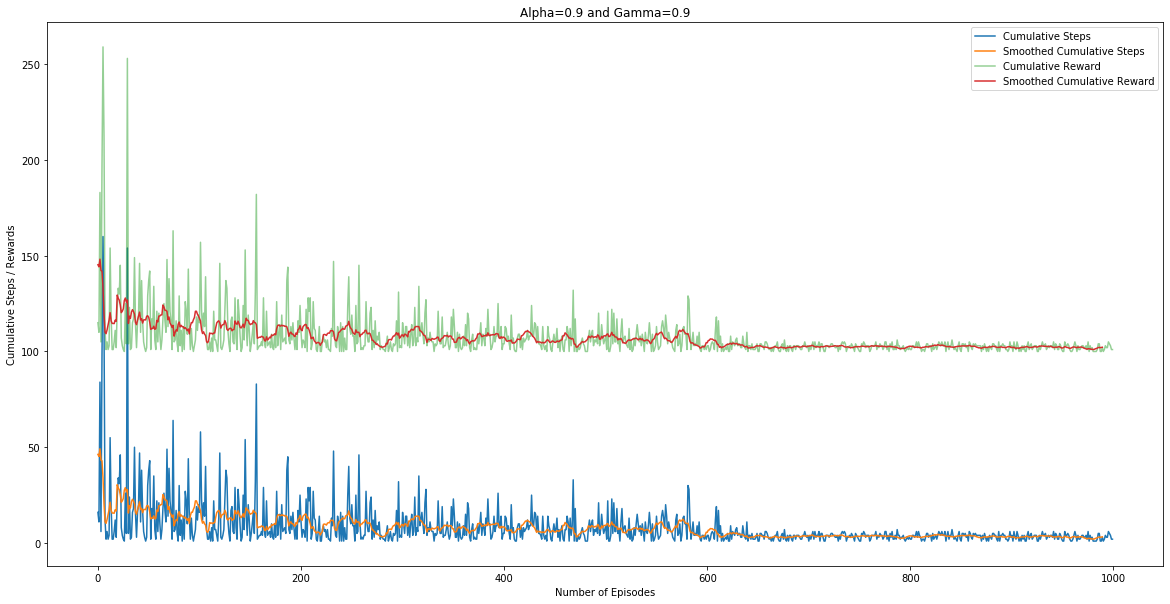

In [36]:
#Qlearning(alpha,gamma, epsilon, episodes,policy):
#alpha,gamma,epsilon-any number between 0 and 1
#episodes - any integer
#policy - 0: random policy, 1: epsilon greedy policy
Qlearning(0.9,0.9,0.99,1000,1)

In [37]:
#Display Q matrix
col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
table = tabulate(Q,col_headers,showindex="always")
print(table)

      0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0  -80    0    0  341  380  -68    0    0    0    0     0   -76   -80     0   -80     0     0   -80     0     0
 1    0    0  380    0  380  380    0    0  468  469     0     0   -80     0     0     0     0     0     0     0
 2    0  422    0  341    0  379  341  -76    0    0     0     0     0     0     0     0     0     0     0     0
 3  341    0  380    0    0    0    0    0   18   -3   -80     0   308     0     0     0     0     0     0     0
 4  341  422    0    0    0  -80    0    0    0    0     0   341     0     0     0     0     0     0     0     0
 5    0  422  380    0  -80  -80  341  341   18    0     0     0     0     0     0     0     0     0     0     0
 6    0  -21  380    0    0  380    0    0    0    0     0     0     0     0     0     0     0  

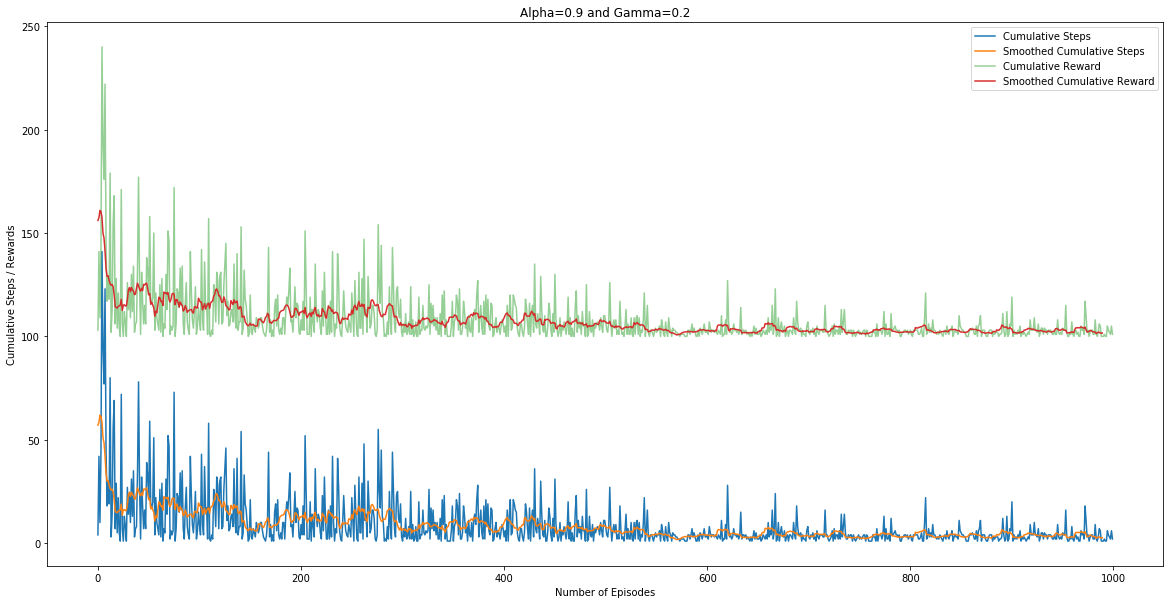

In [43]:
Qlearning(0.9,0.2,0.99,1000,1)

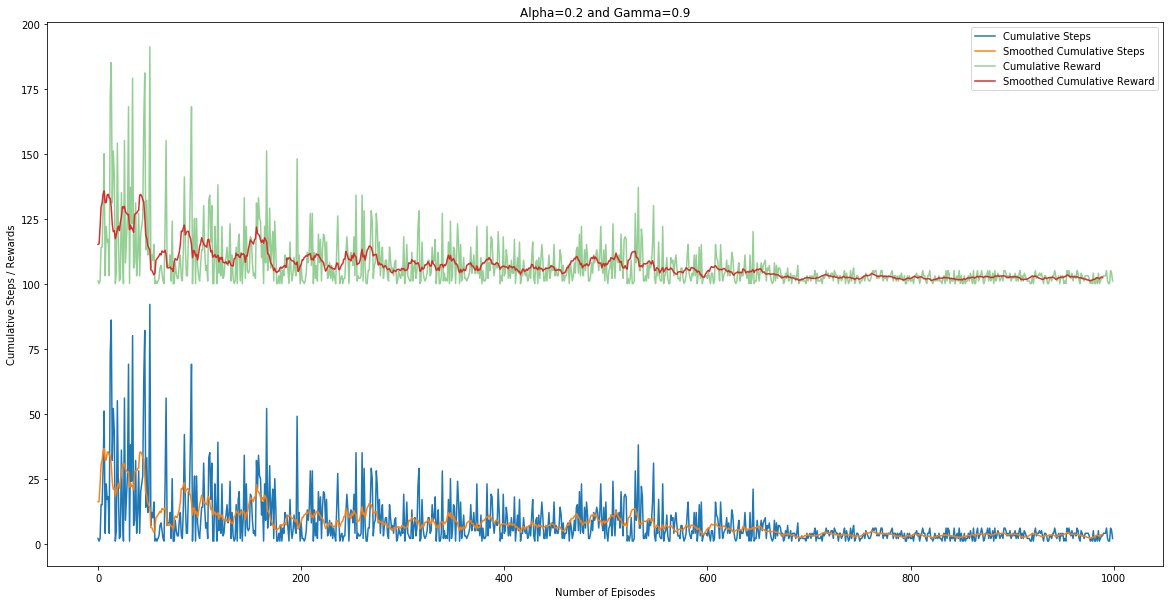

In [38]:
Qlearning(0.2,0.9,0.99,1000,1)

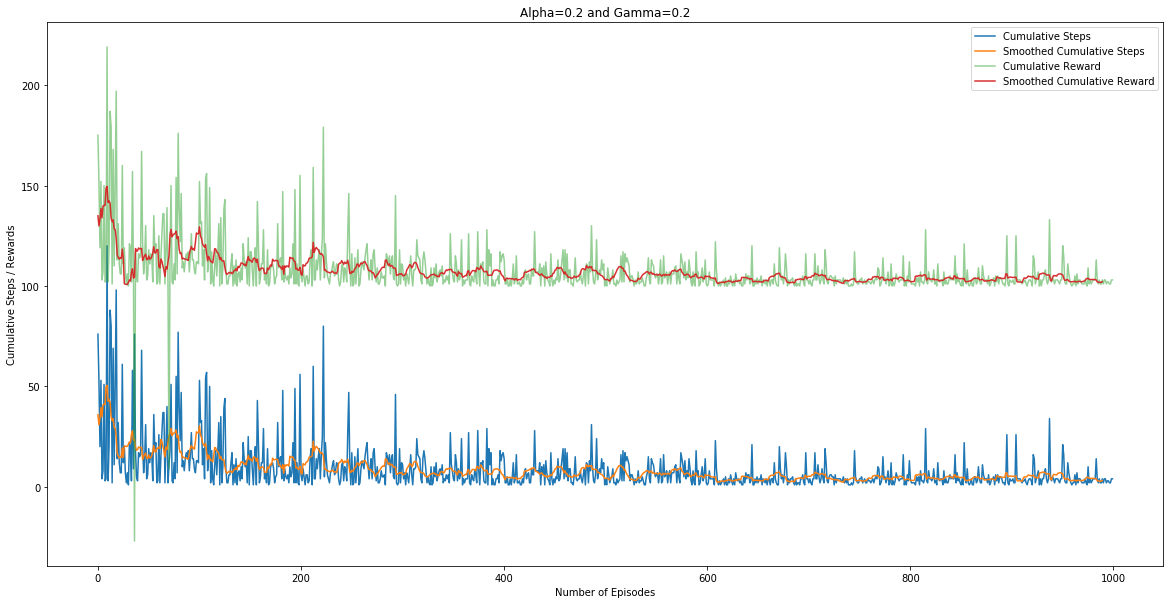

In [39]:
Qlearning(0.2,0.2,0.99,1000,1)

In [40]:
#Display Q matrix
col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
table = tabulate(Q,col_headers,showindex="always")
print(table)

      0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0  -80    0    0    1    2  -68    0    0    0    0     0   -76   -80     0   -80     0     0   -80     0     0
 1    0    0    2    0    2    2    0    0   22   22     0     0   -80     0     0     0     0     0     0     0
 2    0    5    0    1    0    2    1  -76    0    0     0     0     0     0     0     0     0     0     0     0
 3    1    0    2    0    0    0    0    0  -10   -3   -80     0     1     0     0     0     0     0     0     0
 4    1    5    0    0    0  -80    0    0    0    0     0     1     0     0     0     0     0     0     0     0
 5    0    5    2    0  -80  -80    1    1    2    0     0     0     0     0     0     0     0     0     0     0
 6    0  -21    2    0    0    2    0    0    0    0     0     0     0     0     0     0     0  

## Different Policy - Random policy ##

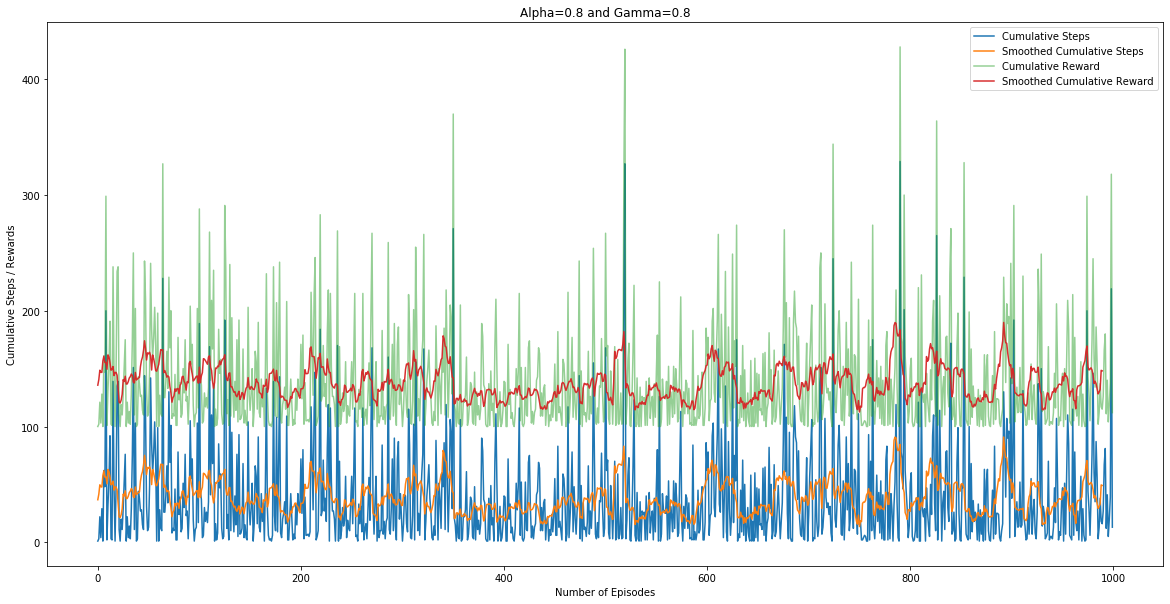

In [34]:
#alpha=0.8
#gamma=0.8
#epsilon=0.99
#episodes=1000;
Qlearning(0.8,0.8,0.99,1000,0) # last parameter is for policy=0, hence random

In [35]:
#Display Q matrix
col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
table = tabulate(Q,col_headers,showindex="always")
print(table)

      0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0  -80    0    0  112  140  -68    0    0    0    0     0   -76   -80     0   -80     0     0   -80     0     0
 1    0    0  140    0  140  140    0    0  219  219     0     0   -80     0     0     0     0     0     0     0
 2    0  175    0  112    0  140  112  -76    0    0     0     0     0     0     0     0     0     0     0     0
 3  112    0  140    0    0    0    0    0   18   -3   -80     0    90     0     0     0     0     0     0     0
 4  112  175    0    0    0  -80    0    0    0    0     0   112     0     0     0     0     0     0     0     0
 5    0  175  140    0  -80  -80  112  112   18    0     0     0     0     0     0     0     0     0     0     0
 6    0  -21  140    0    0  140    0    0    0    0     0     0     0     0     0     0     0  

## Different Start Epsilon value ##

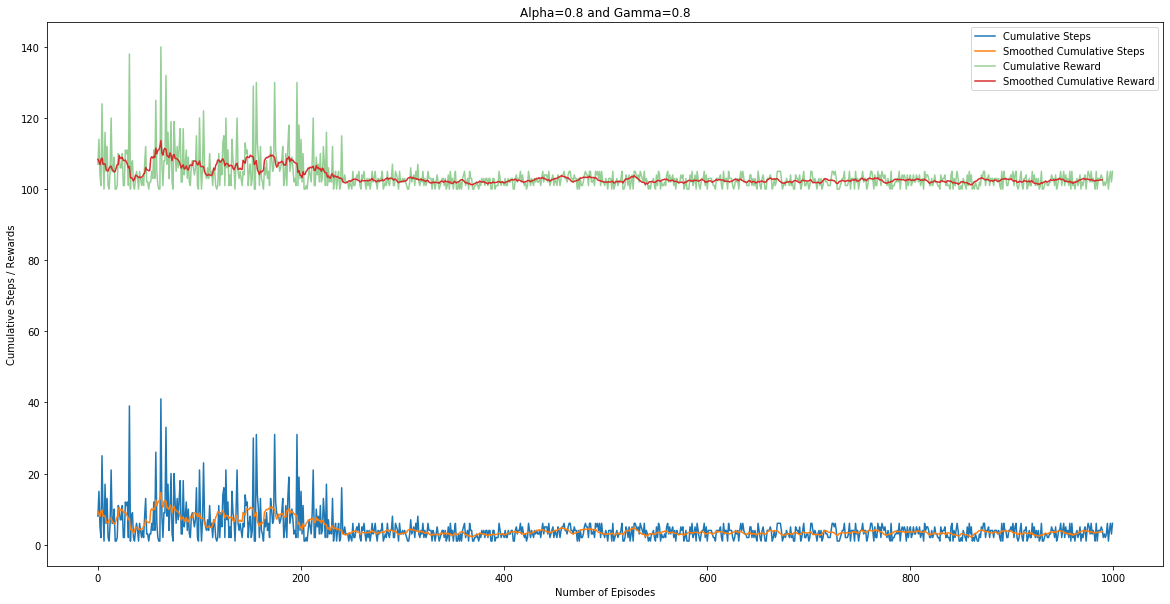

In [41]:
Qlearning(0.8,0.8,0.6,1000,1)

In [42]:
#Display Q matrix
col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
table = tabulate(Q,col_headers,showindex="always")
print(table)

      0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0  -80    0    0  112  140  -68    0    0    0    0     0   -76   -80     0   -80     0     0   -80     0     0
 1    0    0  140    0  139  140    0    0  219  219     0     0   -80     0     0     0     0     0     0     0
 2    0  175    0  112    0  140  112  -76    0    0     0     0     0     0     0     0     0     0     0     0
 3  110    0  140    0    0    0    0    0  -10   -3   -80     0    89     0     0     0     0     0     0     0
 4  112  175    0    0    0  -80    0    0    0    0     0   112     0     0     0     0     0     0     0     0
 5    0  175  140    0  -80  -80  112  112    2    0     0     0     0     0     0     0     0     0     0     0
 6    0  -21  139    0    0  140    0    0    0    0     0     0     0     0     0     0     0  

## Testing Agent performance ##

In [28]:
shortest_path(13,10)

[13, 12, 3, 2, 1, 9, 10]

In [29]:
shortest_path(11,10)

[11, 4, 1, 9, 10]

In [30]:
shortest_path(7,10)

[7, 5, 1, 9, 10]

In [31]:
shortest_path(19,10)

[19, 18, 17, 7, 5, 1, 9, 10]

## Experiment to observe Q value change - Demo of delta learning and update rule ##

### Experiment 1 ###

In [148]:
alpha=0.8;
gamma=0.8;
epsilon=0 # Choosing greedy policy to explain Q value change deterministically
episodes=1;
policy=0;
episode_steps=np.zeros([episodes,1]);
episode_rewards=np.zeros([episodes,1]);
start=9;

Q=np.zeros([20,20])
for i in range(episodes):
    next_node=0;# initialising value for next_node
    step=0;# initialising value for step
    reward=0;
    i=1;
    while start!=10:# Here 10 is the destination node
        next_node=next_state(start,epsilon);
        col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
        print('\n');
        print('Transition ',i, ' : ',start,'->',next_node);
        
        updateQ(start,next_node,alpha,gamma);
        table = tabulate(Q,col_headers,showindex="always");
        print(table)
        
        step=step+1;
        reward=reward+R[start,next_node];
        print('Current Reward : ',R[start,next_node])
        print('Cumulative Reward : ',reward)
        start=next_node;
        i=i+1;  



Transition  1  :  9 -> 18
      0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 1    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 2    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 3    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 4    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 5    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 6    0    0    0    0    0    0    0    0    0    0     0     0    

### Experiment 2 ###

In [78]:
alpha=0.8;
gamma=0.8;
epsilon=0 #Greedy policy to explain Q value change deterministically
episodes=1;
policy=0;
episode_steps=np.zeros([episodes,1]);
episode_rewards=np.zeros([episodes,1]);
start=9;

Q=np.zeros([20,20])
for i in range(episodes):
    next_node=0;# initialising value for next_node
    step=0;# initialising value for step
    reward=0;
    i=1;
    while start!=10:# Here 10 is the destination node
        next_node=next_state(start,epsilon);
        col_headers = ["0", "1","2","3","4","5","6","7","8","9","10","11","12","13","14","15","16","17","18","19"];
        print('\n');
        print('Transition ',i, ' : ',start,'->',next_node);
        
        updateQ(start,next_node,alpha,gamma);
        table = tabulate(Q,col_headers,showindex="always");
        print(table)
        
        step=step+1;
        reward=reward+R[start,next_node];
        print('Current Reward : ',R[start,next_node])
        print('Cumulative Reward : ',reward)
        start=next_node;
        i=i+1;  



Transition  1  :  9 -> 10
      0    1    2    3    4    5    6    7    8    9    10    11    12    13    14    15    16    17    18    19
--  ---  ---  ---  ---  ---  ---  ---  ---  ---  ---  ----  ----  ----  ----  ----  ----  ----  ----  ----  ----
 0    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 1    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 2    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 3    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 4    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 5    0    0    0    0    0    0    0    0    0    0     0     0     0     0     0     0     0     0     0     0
 6    0    0    0    0    0    0    0    0    0    0     0     0    